# Package Import

In [89]:
import os
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import entropy
import seaborn as sns

# Functions

In [2]:
def get_h5(file, hf_file): 
    val = list(hf_file.get(file))
    val = [item.decode('utf-8') for item in val]
    return val

In [15]:
def score(cosine_sim, precedence, cell_names, reverse = False):

    if precedence.shape[0] == cosine_sim.shape[0] and  precedence.shape[1] == cosine_sim.shape[1]:

        rows_atac, cols_rna = precedence.shape
        combined_matrix = np.zeros((rows_atac + cols_rna, rows_atac + cols_rna))


        if reverse == True: 
            precedence = np.divide(1, precedence, out=np.zeros_like(precedence, dtype=float), where=(precedence != 0))
        
        combined_matrix[:rows_atac, rows_atac:rows_atac + cols_rna] = precedence 
        combined_matrix[rows_atac:rows_atac + cols_rna, :rows_atac] =  (cosine_sim.T)
        row_sums = combined_matrix.sum(axis=1, keepdims=True)
        np.divide(combined_matrix, row_sums, out=combined_matrix, where=row_sums!=0)
        ranks = pagerank_efficient(combined_matrix)
    else:
        print("Dimensions dont match")
        return

    return dict(zip(all_cells, ranks))

In [47]:
def pagerank_efficient(T, alpha=0.85, tol=1e-5, max_iter=150):
    n = T.shape[0]
    r = np.ones(n) / n  
    teleport = (1 - alpha) / n  

    for _ in range(max_iter):
        r_new = alpha * T.T.dot(r) + teleport
        if np.linalg.norm(r_new - r, 1) < tol:
            break 
        r = r_new


    return r

In [45]:
def keep_top_k(matrix, K):

    sorted_indices = np.argsort(matrix, axis=1)
    top_k_indices = sorted_indices[:, -K:]
    mask = np.zeros_like(matrix, dtype=bool)
    rows = np.arange(matrix.shape[0])[:, None]
    mask[rows, top_k_indices] = True
    result = np.where(mask, matrix, 0)

    return result

In [48]:
def filter_and_normalize_reverse_matrix(reverse_matrix, rank_list, keep_fraction=0.25):
    cells_to_keep = int(len(rank_list) * keep_fraction)
    reverse_matrix_filtered = reverse_matrix.copy()
    reverse_matrix_filtered = keep_top_k(reverse_matrix_filtered, cells_to_keep)
    
    n_rna = reverse_matrix.shape[0]
    for i in tqdm(range(n_rna)):
        mask = (rank_list > rank_list[i])
        reverse_matrix_filtered[i, ~mask] = 0
    
    row_sums = reverse_matrix_filtered.sum(axis=1, keepdims=True)
    np.divide(reverse_matrix_filtered, row_sums, out=reverse_matrix_filtered, where=row_sums != 0)
    
    return reverse_matrix_filtered

In [66]:
def simulate_multiple_walks(T, start_idx, top_k, num_walkers=100, num_steps=15):

    T = np.asarray(T)
    n_nodes = T.shape[0]
  
    freqs = np.zeros((n_nodes, num_steps + 1), dtype=int)
    walkers = np.full(num_walkers, start_idx, dtype=int)
    alive   = np.ones(num_walkers, dtype=bool)
    freqs[start_idx, 0] = num_walkers

    for step in range(1, num_steps + 1):
        next_walkers = walkers.copy()  
        next_alive   = alive.copy()

        for k in np.where(alive)[0]:
            cur = walkers[k]
            probs = T[cur]
            if probs.sum() == 0:

                next_alive[k] = False
            else:
                next_walkers[k] = np.random.choice(n_nodes, p=probs)
                # remains alive

        counts = np.bincount(next_walkers[next_alive | (~next_alive & alive)], minlength=n_nodes)
        freqs[:, step] = counts
        walkers = next_walkers
        alive   = next_alive
        if not alive.any():
            break

    return freqs

In [79]:
def compute_freq_and_entropy(reverse_matrix_filtered, cell, rna_cell_names__, num_steps=10):
    freq_matrix = np.zeros((reverse_matrix_filtered.shape[0], num_steps + 1), dtype=int)
    H = []


    temp_matrix = simulate_multiple_walks(reverse_matrix_filtered, rna_cell_names_.index(cell), len(rna_cell_names__), num_steps=num_steps)
    H.append(entropy_elbow(temp_matrix))

    freq_matrix += temp_matrix
    return temp_matrix, H

In [70]:
def entropy_elbow(freq_matrix):

    X_probs = freq_matrix / freq_matrix.sum(axis=0, keepdims=True)
    col_entropy = entropy(X_probs, base=2, axis=0)
    x_all = np.arange(freq_matrix.shape[1])

    nz = np.flatnonzero(col_entropy != 0)
    if nz.size < 3:
        return int(nz[-1]) if nz.size > 0 else 0

    start, end = nz[0], nz[-1]
    x = x_all[start:end+1]
    y = col_entropy[start:end+1]


    p1 = np.array([x[0], y[0]], float)
    p2 = np.array([x[-1], y[-1]], float)
    v = p2 - p1
    v /= np.linalg.norm(v)
    pts = np.stack([x, y], axis=1)
    proj = ((pts - p1) @ v[:, None]) * v[None, :]
    dists = np.linalg.norm((pts - p1) - proj, axis=1)
    if dists.size > 2:
        dists[0] = dists[-1] = -np.inf
    elbow_idx_local = int(np.argmax(dists))
    elbow_col = int(x[elbow_idx_local])

    return elbow_col


# Data 
## Cis-TERN assumes the following input:
## 1. scRNA-seq (cell by gene - depth normalized to 10k)
## 2. scATAC-seq (cell by peak - binarized)
## 3. scATAC-seq gene score (from ArchR - depth normalized to 10k)
## 4. peak-gene linkage matrix (from ArchR peak by gene)

The scATAC-seq and scRNA-seq cell names + precedence/cosine similarity matrices can be founded at:

**Dropbox:**  
https://dropbox.com/scl/fo/lcz15wmtypdi8eiratvpl/ABiwETHsDB3V1p-d9Ff0pOo?rlkey=zy0ve4tf89qdlwzajyohypw58&st=q0yd17ln&dl=0

In [ ]:
os.chdir('') # for privacy reasons, path not included
hf = h5py.File('allhema_healthy.h5', 'r')
print("Available files:")
for edge in hf.keys():
    print(f" - {edge}")

Available files:
 - allhema_healthy_atac_cells
 - allhema_healthy_prec_matrix
 - allhema_healthy_rna_cells
 - allhema_healthy_sim_matrix
 - reverse_matrix


In [8]:
#Get scRNA-seq and scATAC-seq cells
rna_cell_names = get_h5("allhema_healthy_rna_cells", hf)
atac_cell_names = get_h5("allhema_healthy_atac_cells", hf)

#Get the precedence (scATAC-seq by scRNA-seq), cosine-similarity (scATAC-seq by scRNA-seq), reverese tracing (scRNA-seq by scRNA-seq) matrices
prec_matrix = np.array(hf.get("allhema_healthy_prec_matrix"))
prec_matrix[prec_matrix < 0] = 0 ##make
cos_matrix = np.array(hf.get("allhema_healthy_sim_matrix"))
reverse_matrix = np.array(hf.get("reverse_matrix"))

print("Precedence matrix shape: ", prec_matrix.shape)
print("Cosine-similarity matrix shape: ", cos_matrix.shape)

print("Number of scRNA-seq cells: ", len(rna_cell_names_))
print("Number of scATAC-seq cells: ", len(atac_cell_names_))


Precedence matrix shape:  (36990, 35582)
Cosine-similarity matrix shape:  (36990, 35582)
Number of scRNA-seq cells:  35582
Number of scATAC-seq cells:  36990


# Forward Tracing

In [20]:
all_cells = atac_cell_names + rna_cell_names
cis_tern_scores = score(cos_matrix, prec_matrix, all_cells, reverse = False)

 33%|███▎      | 50/150 [02:47<05:35,  3.36s/it]


In [ ]:
UMAP_blood_rna = pd.read_csv('path_to_data/rna_blood_umap.csv') # for privacy reasons, full path not included
UMAP_blood_rna = UMAP_blood_rna.loc[UMAP_blood_rna['Cell Name'].isin(rna_cell_names)]
UMAP_blood_rna["score"] = UMAP_blood_rna['Cell Name'].map(cis_tern_scores) 

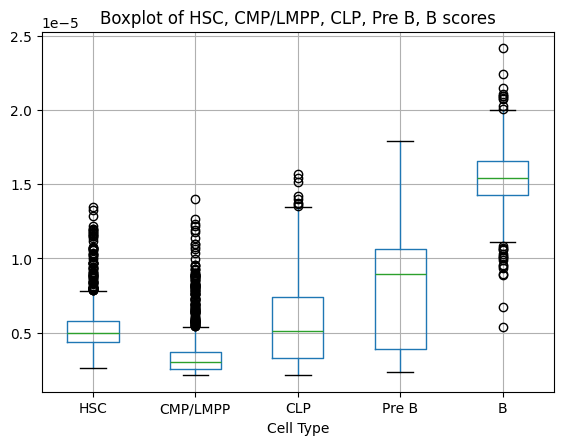

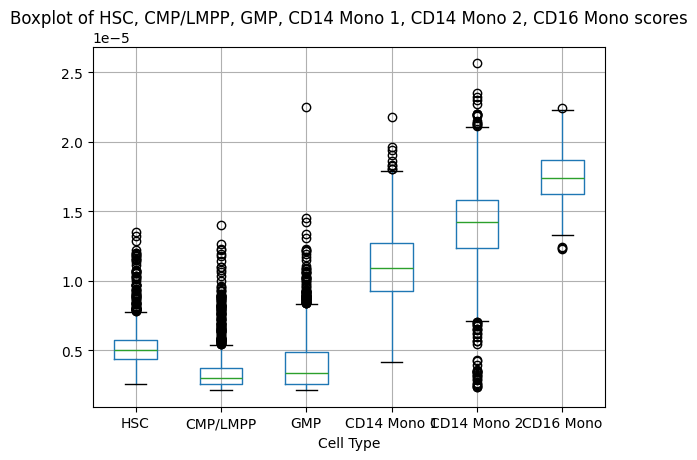

In [43]:
B_lineage =  [ 'HSC', 'CMP/LMPP', 'CLP', 'Pre B', 'B']
Mono_lineage = [ 'HSC', 'CMP/LMPP', 'GMP', 'CD14 Mono 1', 'CD14 Mono 2', 'CD16 Mono']

for lineage in [B_lineage, Mono_lineage]:
    subset = UMAP_blood_rna[UMAP_blood_rna['Cell Type'].isin(lineage)].copy()
    subset['Cell Type'] = pd.Categorical(subset['Cell Type'], categories=lineage, ordered=True)
    ax = subset.boxplot(column='score', by='Cell Type')
    ax.set_title("Boxplot of " + ", ".join(lineage) + " scores")  
    plt.suptitle('') 
    plt.show()


# Reverse Tracing

In [44]:
reverse_cis_tern_scores = score(cos_matrix, prec_matrix, all_cells, reverse = True)

 33%|███▎      | 50/150 [02:48<05:37,  3.37s/it]


In [49]:
reverse_cis_tern_scores_rna = [reverse_cis_tern_scores[cell] for cell in rna_cell_names_]
filtered_matrix = filter_and_normalize_reverse_matrix(reverse_matrix, reverse_cis_tern_scores_rna, keep_fraction=0.25)

100%|██████████| 35582/35582 [01:12<00:00, 488.57it/s]


In [59]:

subset = UMAP_blood_rna[UMAP_blood_rna['Cell Type'] == 'B']
b_cell = np.random.choice(subset['Cell Name'].values)

## CD16 Monocytes

In [102]:
subset = UMAP_blood_rna[UMAP_blood_rna['Cell Type'] == 'CD16 Mono']
cd_16_cell = np.random.choice(subset['Cell Name'].values)
reverse_trace, elbow = compute_freq_and_entropy(filtered_matrix, cd_16_cell, rna_cell_names, num_steps=10)

In [103]:
for i in range(reverse_trace.shape[1]):
    dictionary = dict(zip(rna_cell_names_, reverse_trace[:, i]))
    UMAP_blood_rna[i] = UMAP_blood_rna['Cell Name'].map(dictionary) 

In [104]:
cell_type_walker_mean = UMAP_blood_rna.groupby('Cell Type')[list(range(0,10))].mean()
scaled_mean = (cell_type_walker_mean - cell_type_walker_mean.min(axis=0)) / (cell_type_walker_mean.max(axis=0) - cell_type_walker_mean.min(axis=0))

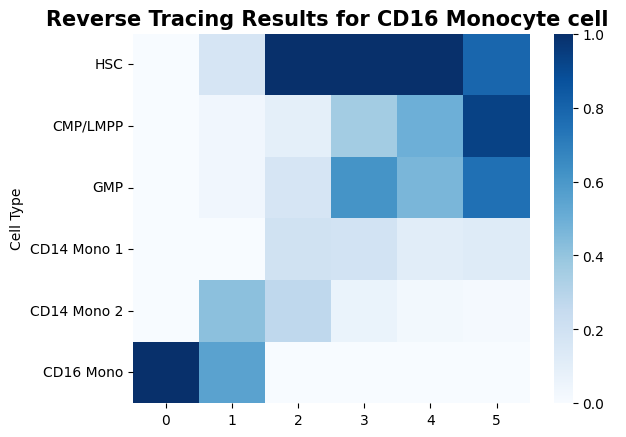

In [105]:
ax = sns.heatmap(scaled_mean[range(0, elbow[0])].loc[Mono_lineage], cmap="Blues")
ax.set_title("Reverse Tracing Results for CD16 Monocyte cell ", fontsize = 15, fontweight = "bold")
plt.show()

## B Cells

In [106]:
reverse_trace, elbow = compute_freq_and_entropy(filtered_matrix, b_cell, rna_cell_names, num_steps=10)

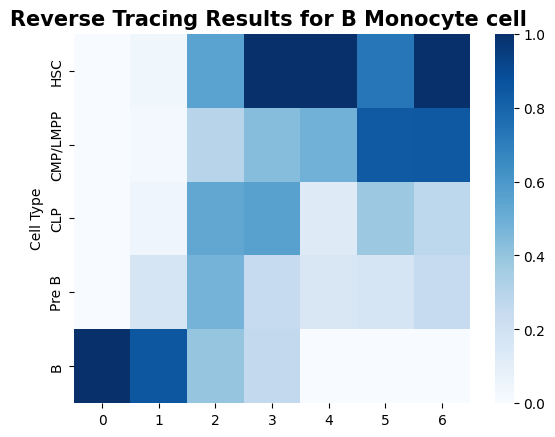

In [107]:
for i in range(reverse_trace.shape[1]):
    dictionary = dict(zip(rna_cell_names_, reverse_trace[:, i]))
    UMAP_blood_rna[i] = UMAP_blood_rna['Cell Name'].map(dictionary) 
cell_type_walker_mean = UMAP_blood_rna.groupby('Cell Type')[list(range(0,10))].mean()
scaled_mean = (cell_type_walker_mean - cell_type_walker_mean.min(axis=0)) / (cell_type_walker_mean.max(axis=0) - cell_type_walker_mean.min(axis=0))
ax = sns.heatmap(scaled_mean[range(0, elbow[0])].loc[B_lineage], cmap="Blues")
ax.set_title("Reverse Tracing Results for B Monocyte cell ", fontsize = 15, fontweight = "bold")
plt.show()